## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_17-27-04-23.csv', firstRow=348, lastRow=354)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_250423_S349-354.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=56s and ended at t=422s; mass=45.11019999999999g
This equals a volume of 45.201m; expected was 45.592mL; error is 0.859%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.00043750000000000006 g/s^2


<IPython.core.display.Javascript object>


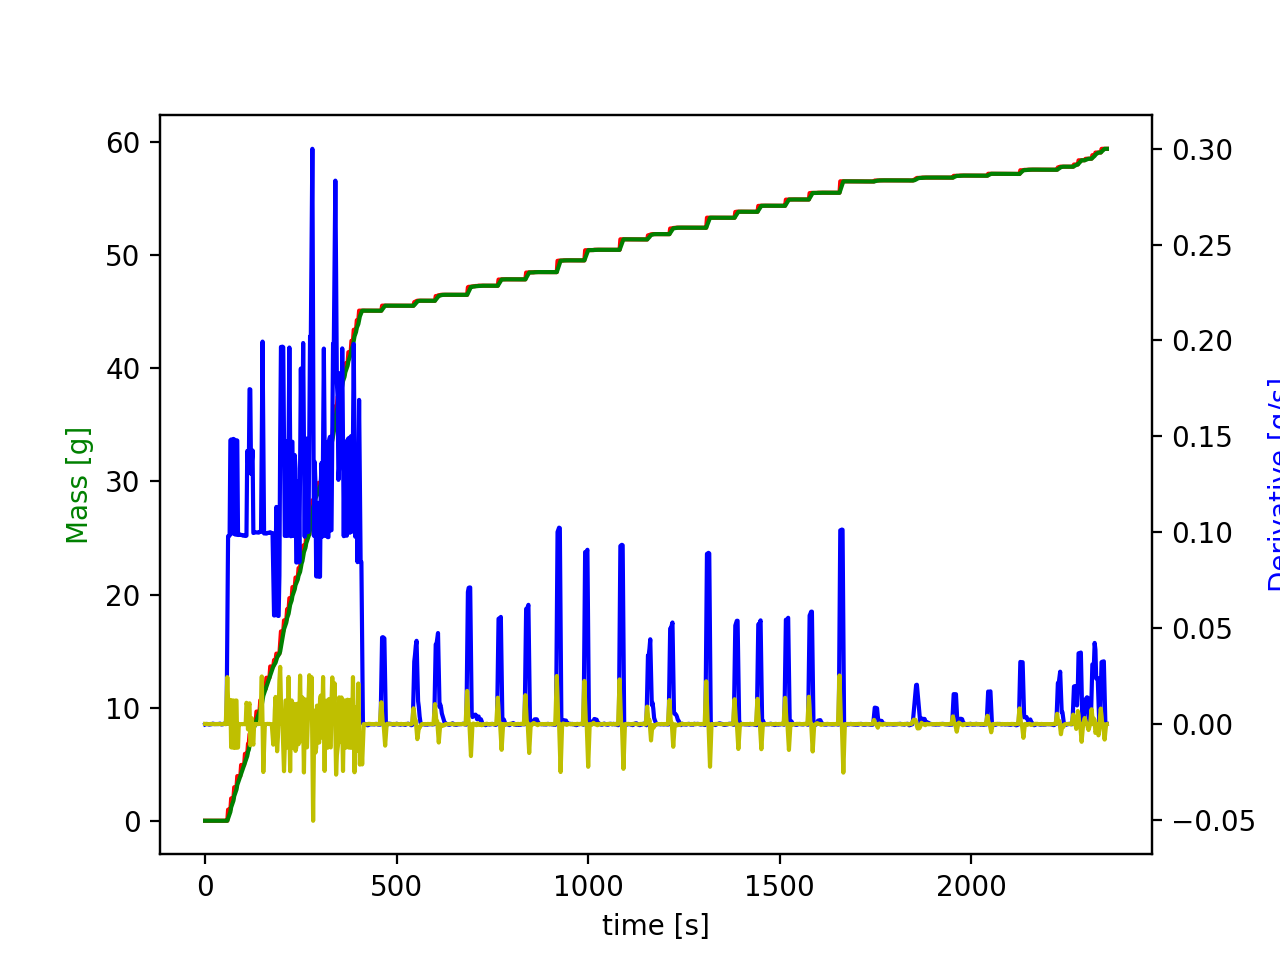

Addition of 0.445g Texapon SB 3 KC detected from 456s to 476s - expected volume = 0.806mL and actual volume = 0.401mL (resulting error is 50.279%)
Addition of 0.444g Plantapon LC 7 detected from 540s to 566s - expected volume = 0.514mL and actual volume = 0.42mL (resulting error is 18.401%)
Addition of 0.531g Plantapon LC 7 detected from 596s to 628s - expected volume = 0.514mL and actual volume = 0.502mL (resulting error is 2.353%)
Addition of 0.807g Plantacare 818 detected from 680s to 726s - expected volume = 0.9mL and actual volume = 0.741mL (resulting error is 17.61%)
Addition of 0.569g Dehyton MC detected from 760s to 786s - expected volume = 0.557mL and actual volume = 0.523mL (resulting error is 6.056%)
Addition of 0.644g Dehyton MC detected from 832s to 872s - expected volume = 0.557mL and actual volume = 0.592mL (resulting error is 6.32%)
Addition of 1.04g Dehyton MC detected from 914s to 946s - expected volume = 0.933mL and actual volume = 0.959mL (resulting error is 2.806%)

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.0018750000000000004 g/s and for 2nd derivative = 0.00078125 g/s^2


<IPython.core.display.Javascript object>


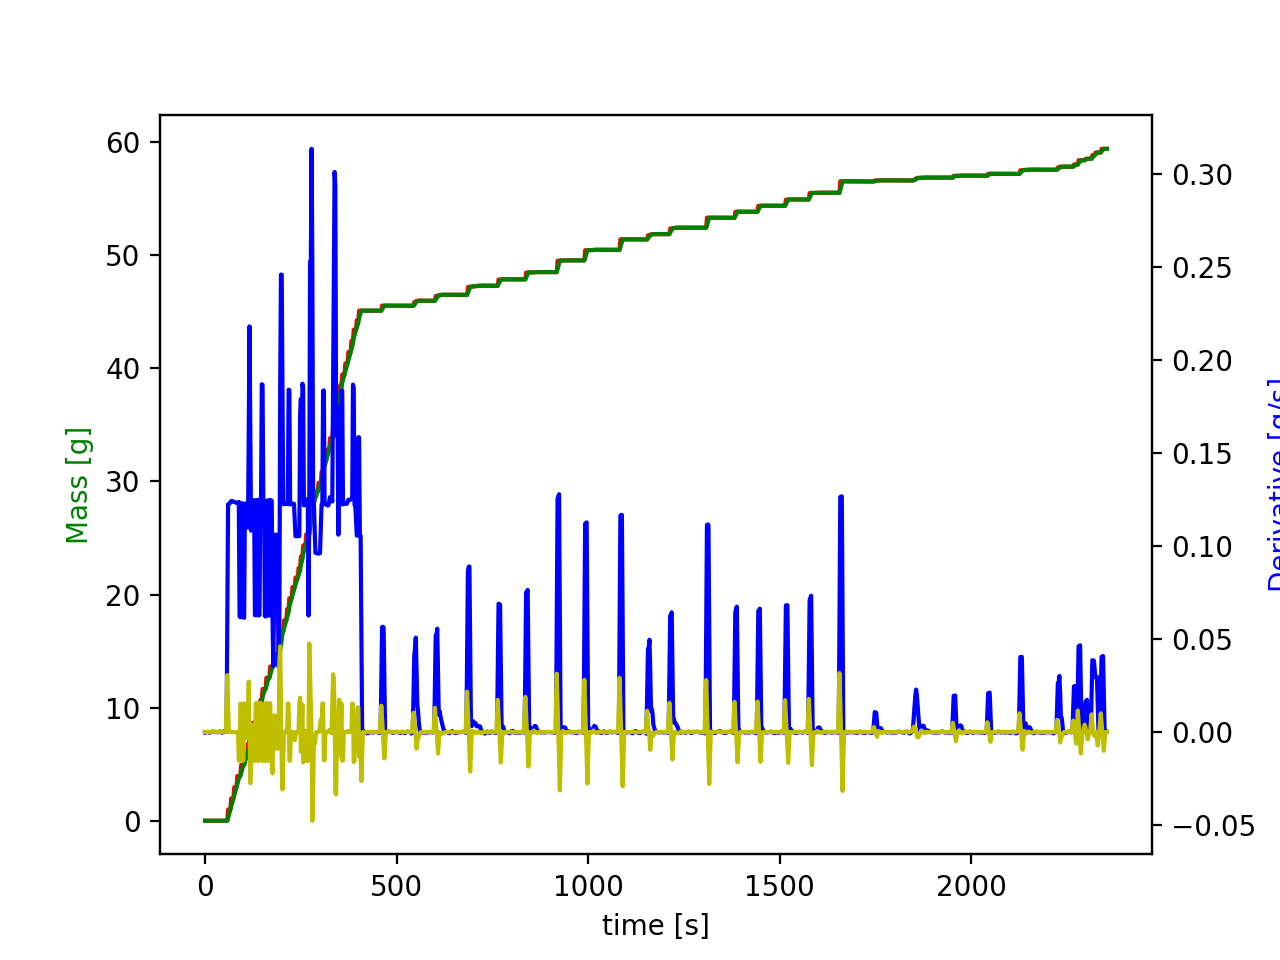

Addition of 0.099g Dehyquart CC7 Benz detected from 1742s to 1768s - expected volume = 0.106mL and actual volume = 0.097mL (resulting error is 8.565%)
Addition of 0.256g Dehyquart CC7 Benz detected from 1846s to 1880s - expected volume = 0.244mL and actual volume = 0.252mL (resulting error is 3.226%)
Addition of 0.179g Dehyquart CC7 Benz detected from 1948s to 1980s - expected volume = 0.165mL and actual volume = 0.175mL (resulting error is 6.473%)
Addition of 0.167g Dehyquart CC7 Benz detected from 2038s to 2056s - expected volume = 0.14mL and actual volume = 0.165mL (resulting error is 17.87%)
Addition of 0.381g Dehyquart CC7 Benz detected from 2122s to 2158s - expected volume = 0.271mL and actual volume = 0.376mL (resulting error is 38.5%)
Addition of 0.273g Dehyquart CC7 Benz detected from 2220s to 2244s - expected volume = 0.213mL and actual volume = 0.27mL (resulting error is 26.802%)


In [4]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2226,2280,2400,2500,2600,2700,2800])

## Analyse Thickeners

<IPython.core.display.Javascript object>


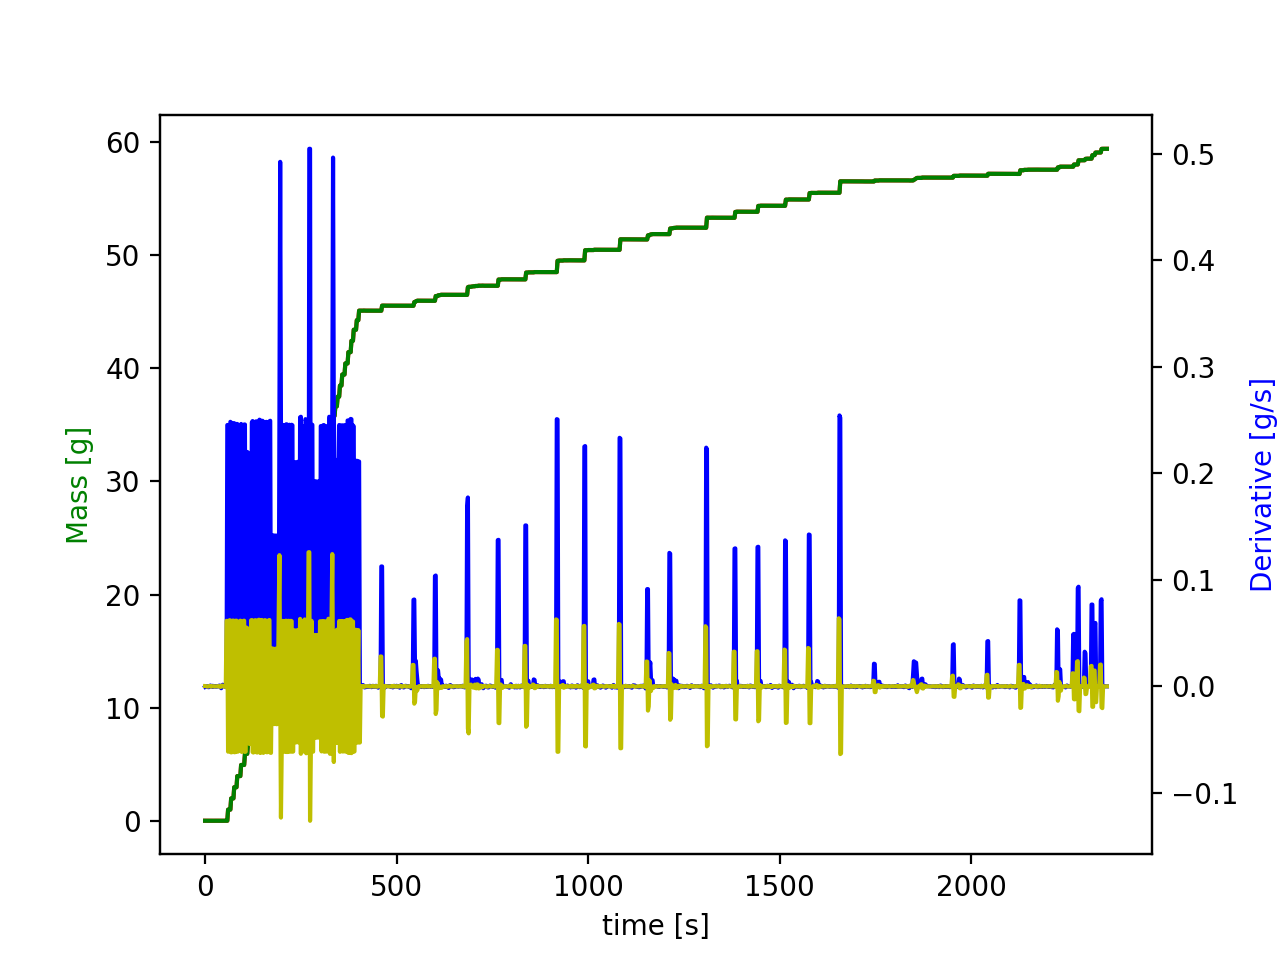

Addition of 0.197g Arlypon F detected from 2264s to 2272s - expected volume = 0.216mL and actual volume = 0.224mL (resulting error is 3.684%)
Addition of 0.37g Arlypon F detected from 2272s to 2284s - expected volume = 0.406mL and actual volume = 0.421mL (resulting error is 3.641%)
Addition of 0.139g Arlypon F detected from 2284s to 2306s - expected volume = 0.139mL and actual volume = 0.157mL (resulting error is 13.008%)
Addition of 0.311g Arlypon F detected from 2306s to 2318s - expected volume = 0.331mL and actual volume = 0.355mL (resulting error is 7.241%)
Addition of 0.237g Arlypon F detected from 2318s to 2328s - expected volume = 0.254mL and actual volume = 0.27mL (resulting error is 6.278%)
Addition of 0.328g Arlypon F detected from 2328s to 2346s - expected volume = 0.355mL and actual volume = 0.375mL (resulting error is 5.806%)


In [5]:
# default bl_mult = 1, default mergeSens = 1
#t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2264,2272,2284,2306,2318,2328,2346])

## Consolidate results and create output

In [7]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
#actualMassFractions.to_csv('mass_data/FreshlyAnalysed_250423_S349-S354.csv', index=False)
actualMassFractions

,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
348,349.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,17.049901,14.528056,0.0,0.000000,0.0,0.0,0.0,1.618143,0.0,3.228093,0.0
349,350.0,0.000000,0.0,0.000000,0.000000,0.0,18.482734,0.000000,0.000000,0.000000,0.0,17.663378,0.0,0.0,0.0,3.898797,0.0,5.634980,0.0
350,351.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,17.070242,0.0,16.136813,0.0,0.0,0.0,2.859026,0.0,2.221689,0.0
351,352.0,0.000000,0.0,15.513853,0.000000,0.0,16.552776,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,2.662938,0.0,4.948014,0.0
352,353.0,0.000000,0.0,0.000000,0.000000,0.0,14.748822,14.583547,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,5.995152,0.0,3.730492,0.0
353,354.0,7.783295,0.0,0.000000,14.092044,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,4.763009,0.0,5.730462,0.0
